# [ `GoPiGo` ] Autopilot with Keras & TensorFlow
---

```
DSCI6005: Deep Learning
University of New Haven - GalvanizeU
Final Project
Author: Jeremy Grace
```

In [1]:
import os
import urllib.request
import pickle
import matplotlib
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
from keras import callbacks
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ZeroPadding2D
from keras.layers import Dropout, Flatten, Dense

%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
from keras import backend as K

sess = tf.Session()
K.set_session(sess)

---
### Load driving data from AWS

#### $Description\ of\ Dataset$
>The dataset is composed of ~7900 images and steering angles collected as I manually drove the car. About 2/3 of the images are with the car between the lines. The other third is of the car starting off course and correcting by driving back to between the lines.

In [3]:
# driving data size: (450Mb) 
driv_data = 'https://s3.amazonaws.com/donkey_resources/indoor_lanes.pkl'
fpath, headers = urllib.request.urlretrieve(driv_data)
print(fpath)

/tmp/tmpm4822h9j


X.shape:  (7892, 120, 160, 3)
Y.shape:  (7892,)


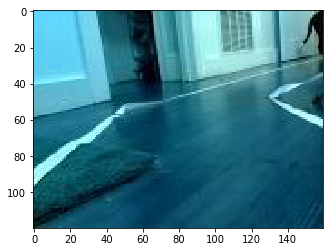

In [4]:
with open(fpath, 'rb') as f:
    X, Y = pickle.load(f)
    
print('X.shape: ', X.shape)
print('Y.shape: ', Y.shape)
imshow(X[3]);

In [5]:
print(Y[:50])

[ 1  1  1  1  1  1  1  1  4  0  2  3  3  4  6  7  8  8 10 12 15 20 21 21 22
 22 18 16 14 11  9  8  8  7  7  4  3 -3 -3 -3  0 12 13 19 23  6 20 21 23 25]


### Split Data

* rationale??

In [6]:
#shuffle both X and Y the same way
def unison_shuffled_cp(X, Y):
    assert len(X) == len(Y)
    p = np.random.permutation(len(X))
    return X[p], Y[p]

shuffled_X, shuffled_Y = unison_shuffled_cp(X,Y)

len(shuffled_X)

7892

In [7]:
# 80% of data used for training
test_cutoff = int(len(X) * 0.8)
# 10% of data used for validation and test data 
val_cutoff = test_cutoff + int(len(X) * 0.1)

train_X, train_Y = shuffled_X[:test_cutoff], shuffled_Y[:test_cutoff]
val_X, val_Y = shuffled_X[test_cutoff:val_cutoff], shuffled_Y[test_cutoff:val_cutoff]
test_X, test_Y = shuffled_X[val_cutoff:], shuffled_Y[val_cutoff:]

len(train_X) + len(val_X) + len(test_X)

7892

### Augment Training Data

* rationale

In [8]:
X_flipped = np.array([np.fliplr(i) for i in train_X])
Y_flipped = np.array([-i for i in train_Y])
train_X = np.concatenate([train_X, X_flipped])
train_Y = np.concatenate([train_Y, Y_flipped])
len(train_X)

12626

---
## Build a driving model

>**Enhancements**:
>Added the following layers (see below):
> * 2 **new** ZeroPadding2D layers
> * 2 **new** Conv2D layers with corresponding ReLU activations
> * And one more **new** set of Dense, Activation ('ReLU' this time), and Dropout series
> Inspired by similar sequential block arrangements in [VGG16 architecture](https://github.com/fchollet/keras/blob/master/keras/applications/vgg16.py)
> > _No deletions_


            img_in = Input(shape=(120, 160, 3), name='img_in')
            angle_in = Input(shape=(1,), name='angle_in')

            x = Conv2D(8, (3, 3))(img_in)
            x = Activation('relu')(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)

            x = Conv2D(16, (3, 3))(x)
            x = Activation('relu')(x)
    -->     x = ZeroPadding2D((1,1))(x)
    -->     x = Conv2D(16, (3, 3))(x)
    -->     x = Activation('relu')(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)

            x = Conv2D(32, (3, 3))(x)
            x = Activation('relu')(x)
    -->     x = ZeroPadding2D((1,1))(x)
    -->     x = Conv2D(32, (3, 3))(x)
    -->     x = Activation('relu')(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)

            merged = Flatten()(x)

            x = Dense(256)(merged)
    -->     x = Activation('relu')(x)
    -->     x = Dropout(.2)(x)
    -->     x = Dense(256)(x)
            x = Activation('linear')(x)
            x = Dropout(.2)(x)

            angle_out = Dense(1, name='angle_out')(x)


In [3]:
img_in = Input(shape=(120, 160, 3), name='img_in')
angle_in = Input(shape=(1,), name='angle_in')

x = Conv2D(8, (3, 3))(img_in)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(16, (3, 3))(x)
x = Activation('relu')(x)
x = ZeroPadding2D((1,1))(x)
x = Conv2D(16, (3, 3))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(32, (3, 3))(x)
x = Activation('relu')(x)
x = ZeroPadding2D((1,1))(x)
x = Conv2D(32, (3, 3))(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

merged = Flatten()(x)

x = Dense(256)(merged)
x = Activation('relu')(x)
x = Dropout(.2)(x)
x = Dense(256)(x)
x = Activation('linear')(x)
x = Dropout(.2)(x)

angle_out = Dense(1, name='angle_out')(x)

model = Model(inputs=[img_in], outputs=[angle_out])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 120, 160, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 118, 158, 8)       224       
_________________________________________________________________
activation_1 (Activation)    (None, 118, 158, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 79, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 77, 16)        1168      
_________________________________________________________________
activation_2 (Activation)    (None, 57, 77, 16)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 59, 79, 16)        0         
__________

In [4]:
from IPython.display import display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = tf.compat.as_bytes("<stripped %d bytes>"%size)
    return strip_def
  
def rename_nodes(graph_def, rename_func):
    res_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = res_def.node.add() 
        n.MergeFrom(n0)
        n.name = rename_func(n.name)
        for i, s in enumerate(n.input):
            n.input[i] = rename_func(s) if s[0]!='^' else '^'+rename_func(s[1:])
    return res_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))
  
    iframe = """
        <iframe seamless style="width:800px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

show_graph(sess.graph)

---
## Train the model

>**Ehancements**:
> * Originally, ran the new model with the same parameters. Increased the `epochs` from $4$ to $10$ and find much better results

In [11]:
model_path = os.path.expanduser('~/best_autopilot_v2.hdf5')

# Save the model after each epoch if the validation loss improved.
save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, 
                                     save_best_only=True, mode='min')

# Stop training if the validation loss doesn't improve for 5 consecutive epochs.
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                                     verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]

In [13]:
model.fit(train_X, train_Y, batch_size=64, epochs=10, validation_data=(val_X, val_Y), callbacks=callbacks_list)

Train on 12626 samples, validate on 789 samples
Epoch 1/10
12626/12626 [==============================] - 196s - loss: 587.0171 - val_loss: 342.8053
Epoch 2/10
12626/12626 [==============================] - 196s - loss: 271.9848 - val_loss: 237.5128
Epoch 3/10
12626/12626 [==============================] - 196s - loss: 206.8134 - val_loss: 200.6252
Epoch 4/10
12626/12626 [==============================] - 196s - loss: 164.7227 - val_loss: 203.3716
Epoch 5/10
12626/12626 [==============================] - 196s - loss: 139.3610 - val_loss: 165.5561
Epoch 6/10
12626/12626 [==============================] - 196s - loss: 113.7990 - val_loss: 196.6068
Epoch 7/10
12626/12626 [==============================] - 196s - loss: 106.6405 - val_loss: 173.0781
Epoch 8/10
12626/12626 [==============================] - 196s - loss: 95.4267 - val_loss: 161.8480
Epoch 9/10
12626/12626 [==============================] - 196s - loss: 87.3144 - val_loss: 179.9084
Epoch 10/10
12626/12626 [====================

### Evaluate Performance

In [14]:
model = load_model(model_path)
test_P = model.predict(test_X)
test_P = test_P.reshape((test_P.shape[0],))

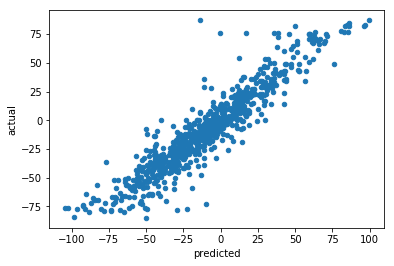

In [15]:
df = pd.DataFrame({'predicted':test_P, 'actual':test_Y})
ax = df.plot.scatter('predicted', 'actual')

>With the new model, `predicted` data forms a much tighter formation with less residuals and clearly defined positive linear relationship to the `actuals`.

---
Compared to: $$Will\ Roscoe's\ baseline\ CNN$$

![W.Roscoe - eval1](img/eval1.png)

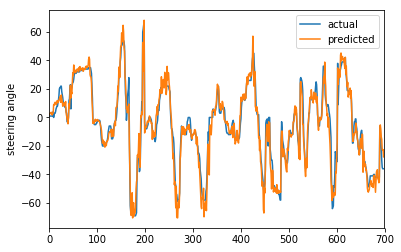

In [16]:
P = model.predict(X[:700])
# Reshape needed to plot due to nexted arrays
P = P.reshape((P.shape[0],)) 

ax = pd.DataFrame({'predicted':P, 'actual':Y[:700]}).plot()
ax.set_ylabel("steering angle");

>This deeper CNN definitely shows promise in comparsion to the original CNN model from Roscoe. As you can see, the new model better aligns the `predicted` with the `actuals` values.

---
Compared to: $$Will\ Roscoe's\ baseline\ CNN$$

![W.Roscoe -- eval2](img/eval2.png)

---
## Next steps

* Integrate Deep CNN into Raspberry Pi/ GoPiGo for autopilot functionality and then optimize
* Build another model(s) incorporating LSTM and TimeDistributed layers given the time aspect of the video/frames
* Eventually, the main goal is to build a `self-driving-car` library for Dexter Industries GoPiGo.


`Reference:`
Will Roscoe - Lane Following Autopilot with Keras & Tensorflow
https://wroscoe.github.io/keras-lane-following-autopilot.html
